In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_images.shape

(60000, 28, 28, 1)

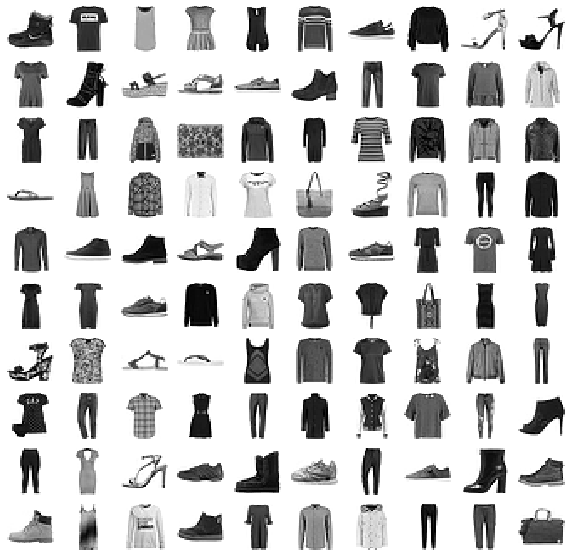

In [5]:
plt.rcParams["figure.figsize"] = (10,10)
for i in range(100):
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')
    plt.imshow(train_images[i][:,:,0], cmap='gray_r')
plt.show()

In [6]:
def make_generator_model(latent_dim=100, num_classes=10):
    in_label = layers.Input(shape=(1,))
    li = layers.Embedding(num_classes, 50)(in_label)
    n_nodes = 7 * 7
    li = layers.Dense(n_nodes)(li)
    li = layers.Reshape((7, 7, 1))(li)
    
    in_lat = layers.Input(shape=(latent_dim,))
    n_nodes = 256 * 7 * 7
    gen = layers.Dense(n_nodes)(in_lat)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    gen = layers.Reshape((7, 7, 256))(gen)
    merge = layers.Concatenate()([gen, li])

    gen = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(merge)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)

    gen = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)
    

    out_layer = layers.Conv2DTranspose(1, (7, 7), padding='same', activation='tanh')(gen)
    
    model = tf.keras.Model((in_label,in_lat),out_layer)
    return model
    
    

In [7]:
def make_discriminator_model(num_classes=10,in_shape=(28,28,1)):

    input1 = layers.Input(shape=(1,))
    li = layers.Embedding(num_classes, 50)(input1)
    n_nodes = in_shape[0] * in_shape[1]
    li = layers.Dense(n_nodes)(li)
    li = layers.Reshape((in_shape[0], in_shape[1], 1))(li)
    
    input2 = tf.keras.Input(shape=in_shape)
    
    merge = layers.Concatenate()([li, input2])
    dis = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(merge)
    dis = layers.LeakyReLU()(dis)
    dis = layers.Dropout(0.3)(dis)

    dis = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(dis)
    dis = layers.LeakyReLU()(dis)
    dis = layers.Dropout(0.3)(dis)

    dis = layers.Flatten()(dis)
    outputs = layers.Dense(1)(dis)

    return tf.keras.Model(inputs=(input1, input2), outputs=outputs)

In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [9]:
generator = make_generator_model()
discriminator = make_discriminator_model()

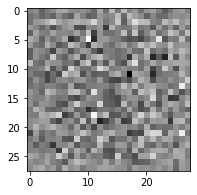

In [10]:
plt.rcParams["figure.figsize"] = (3,3)
noise = tf.random.normal([1, 100])
generated_image = generator((train_labels[:1].astype(np.float32),noise))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
discriminator((train_labels[:1].astype(np.float32),generated_image))

<tf.Tensor: id=935, shape=(1, 1), dtype=float32, numpy=array([[0.00177938]], dtype=float32)>

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [13]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

In [58]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
dataset,_ = tf.keras.datasets.fashion_mnist.load_data()
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
labels_seed = tf.random.uniform( 
    shape=[num_examples_to_generate, 1],
    minval=0,
    maxval=9,
    dtype=tf.dtypes.float32,
)


In [64]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    print(noise.shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator((labels,noise), training=True)

      real_output = discriminator((labels, images), training=True)
      fake_output = discriminator((labels, generated_images), training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [65]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch,labels_batch in dataset:
      labels_batch = tf.reshape(labels_batch,(-1,1))
        
      train_step(image_batch, labels_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             (seed,labels_seed))

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           (seed,labels_seed))

In [66]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [67]:
%%time
train(train_dataset, EPOCHS)

(256, 100)


TypeError: in converted code:

    <ipython-input-64-19772b92aa2c>:10 train_step  *
        real_output = discriminator((labels, images), training=True)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/network.py:708 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/network.py:860 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/layers/merge.py:182 call
        return self._merge_function(inputs)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/layers/merge.py:394 _merge_function
        return K.concatenate(inputs, axis=self.axis)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/backend.py:2708 concatenate
        return array_ops.concat([to_dense(x) for x in tensors], axis)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/dispatch.py:180 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/array_ops.py:1431 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/gen_array_ops.py:1257 concat_v2
        "ConcatV2", values=values, axis=axis, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/op_def_library.py:499 _apply_op_helper
        raise TypeError("%s that don't all match." % prefix)

    TypeError: Tensors in list passed to 'values' of 'ConcatV2' Op have types [float32, uint8] that don't all match.


In [63]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 784)       39984       embedding_1[0][0]                
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 28, 28, 1)    0           dense_2[0][0]                    
____________________________________________________________________________________________